# Simulated_Echo_SVC-2020-L
## Claude de Rijke-Thomas
### 21st May 2021

In [1]:
import scipy.io
import numpy as np
from scipy.integrate import simps, trapz
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from numba import jit, prange
from scipy import signal
from scipy.interpolate import interp1d
from scipy import signal

# The Lead Part (Including Lead SVC)

alphabetically:
$$D\_off = [0, 200, 400, 600, 800, 1000]; % distance off nadir (default = 0 m)$$
$$h\_s = [0, 0.05, 0.10, 0.15, 0.20, 0.25, 0.30, 0.35]; % snow depth, m$$
$$L\_ang = [0:10:90]; %lead angle from the across-track direction (between 0\u00B0 and 90\u00B0)$$
$$L\_w = [0:50:300]; % lead width (default = 100 m)$$

In [2]:
waveform = np.loadtxt('/Users/claudederijkethomas/Desktop/Ice/Proj/CS_OFFL_SIR_SAR_1B_20140515T080546_20140515T081235_B001.wfm')



In [3]:
#Lead echo simulations (first part of three, corresponding to snow depths of 0 to 15cm):
LP1 = scipy.io.loadmat('/Users/claudederijkethomas/Desktop/Ice/Proj/FEM_Sim_LP1.mat')#h_s = [0 0.05 0.10 0.15];
LP2 = scipy.io.loadmat('/Users/claudederijkethomas/Desktop/Ice/Proj/FEM_Sim_LP2.mat')#h_s = [0.20 0.25 0.30 0.35]

#added arrays containing values of the parameters iterated over (to be used as SVC labels):
sim_params_1 = LP1['parameters_lookup']
sim_params_2 = LP2['parameters_lookup']


#simulated lead-containing waveforms:
sim_echoes_1 = LP1['P_t_ml_range']
sim_echoes_2 = LP2['P_t_ml_range']


fasttimes_1= LP1['t']
fasttimes_2= LP2['t']


In [4]:
interpolation_factor = 100
gaussian = [(1/(5*np.sqrt(2*np.pi)))*np.exp(-((x - 35)**2)/(2*5**2)) for x in range(100)]
gauss_xnew = np.linspace(0, len(gaussian)-1, num=(len(gaussian)*interpolation_factor), endpoint=True)
gauss_interpolator = interp1d((range(len(gaussian))), gaussian, kind='cubic')
gauss_interpolation = gauss_interpolator(gauss_xnew)
gauss_interp_peak_index = np.argmax(gauss_interpolation) #the peak index of the interpolated gaussian
gauss_interp_left_base = scipy.signal.peak_prominences(gauss_interpolation, [gauss_interp_peak_index], wlen=300*interpolation_factor)[1][0] #index of the left hand side base of the peak
print("gauss_interp_left_base",gauss_interp_left_base)
#the leading edge centroid of the interpolated gaussian:
gauss_interp_leading_edge_halfway_up_index = np.argmin(abs(gauss_interpolation[:np.argmax(gauss_interpolation)] - np.max(gauss_interpolation)/2))
print("leading edge halfway up index: ",gauss_interp_leading_edge_halfway_up_index)
halfway_up_uninterp_index = int(gauss_interp_leading_edge_halfway_up_index/interpolation_factor)

gauss_interp_left_base 0
leading edge halfway up index:  2940


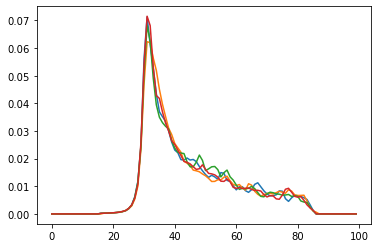

In [6]:
def extractL():
    """extracting (and preprocessing) the simulated echo arrays into a format that can be understood by the SVC."""
    counter = 0
    graph_plot_counter = 0
    feature_arr = []
    label_arr = []
    int_label_arr = []
    for i in range(len(sim_echoes_1[:][:][:][:])): 
        for j in range(len(sim_echoes_1[0][:][:][:])): 
            for k in range(len(sim_echoes_1[0][0][:][:])): 
                for l in range(len(sim_echoes_1[0][0][0][:])):
                    
                    """ Get rid of the %2 if time_sampling_factor = 1"""
                    simulated_echo = [sim_echoes_1[i][j][k][l][m][0] for m in range(len(sim_echoes_1[i][j][k][l])) if m%2==0 ]
                    sim_echo_params = [sim_params_1[i][j][k][l][0][n] for n in range(len(sim_params_1[i][j][k][l][0]))]
                    simulated_echo_area = trapz(simulated_echo, dx = 1) 
                    norm_sim_echo = [x/simulated_echo_area for x in simulated_echo]
                    
                    sim_xnew = np.linspace(0, len(norm_sim_echo)-1, num=(len(norm_sim_echo)*interpolation_factor), endpoint=True)
                    sim_interpolator = interp1d((range(len(norm_sim_echo))), norm_sim_echo, kind='cubic')
                    sim_interpolation = sim_interpolator(sim_xnew)
                    
                    sim_interp_peak_index = np.argmax(sim_interpolation)
                    sim_interp_left_base = scipy.signal.peak_prominences(sim_interpolation, [sim_interp_peak_index])[1][0] #index of the left hand side base of the peak

                    """new stuff added – trying to align to the halway up point of the leading edges instead of the centroid of the leading edge"""
                    step_index = sim_interp_left_base
                    #climbing up the leading edge of the echo to get the index of the halfway point (j):
                    while sim_interpolation[step_index]<(sim_interpolation[sim_interp_left_base]+sim_interpolation[sim_interp_peak_index])/2:
                        step_index = step_index + 1
                    sim_interp_leading_edge_halfway_up_index = step_index
                    
                    sim_gauss_interp_leading_edge_halfway_up_shift = -(sim_interp_leading_edge_halfway_up_index-gauss_interp_leading_edge_halfway_up_index)
                    
                    arr_sim_interp = []
                    #lining up the simulated echo's halfway up point with the abstract gaussian's halway up the leading edge point: 
                    for a in range(len(gauss_interpolation)):
                        try:
                            #So that I dont accidentally start plotting the -10th, -9th index etc:
                            if a-int(sim_gauss_interp_leading_edge_halfway_up_shift)>=0:
                                arr_sim_interp.append(sim_interpolation[a-int(sim_gauss_interp_leading_edge_halfway_up_shift)])
                            else:
                                arr_sim_interp.append(0)
                        except:
                            arr_sim_interp.append(0)
                    #uninterpolating the simulated echo:
                    sim_uninterp = [arr_sim_interp[b] for b in range(len(arr_sim_interp)) if b%interpolation_factor==0]
                    """ ending new stuff"""
                    if graph_plot_counter<4: 
                        plt.plot(sim_uninterp)
                        graph_plot_counter+=1
                    
                    #appending the leading edge to the feature_arr, as well as the whole echo after it (so that the leading edge has more of an effect on the classification):
                    feature_arr.append(np.append(sim_uninterp[halfway_up_uninterp_index-10:halfway_up_uninterp_index+10],sim_uninterp))
                    #appending echo parameters to a label array (for the classification)
                    label_arr.append(str(sim_echo_params))
                    int_label_arr.append(counter)
                    counter+=1
    for i in range(len(sim_echoes_2[:][:][:][:])): 
        for j in range(len(sim_echoes_2[0][:][:][:])): 
            for k in range(len(sim_echoes_2[0][0][:][:])): 
                for l in range(len(sim_echoes_2[0][0][0][:])):
                    
                    """ Get rid of the %2 if time_sampling_factor = 1"""
                    simulated_echo = [sim_echoes_2[i][j][k][l][m][0] for m in range(len(sim_echoes_2[i][j][k][l])) if m%2==0 ]
                    sim_echo_params = [sim_params_2[i][j][k][l][0][n] for n in range(len(sim_params_2[i][j][k][l][0]))]
                    simulated_echo_area = trapz(simulated_echo, dx = 1) 
                    norm_sim_echo = [x/simulated_echo_area for x in simulated_echo]
                    
                    sim_xnew = np.linspace(0, len(norm_sim_echo)-1, num=(len(norm_sim_echo)*interpolation_factor), endpoint=True)
                    sim_interpolator = interp1d((range(len(norm_sim_echo))), norm_sim_echo, kind='cubic')
                    sim_interpolation = sim_interpolator(sim_xnew)
                    
                    sim_interp_peak_index = np.argmax(sim_interpolation)
                    sim_interp_left_base = scipy.signal.peak_prominences(sim_interpolation, [sim_interp_peak_index])[1][0] #index of the left hand side base of the peak

                    """new stuff added – trying to align to the halway up point of the leading edges instead of the centroid of the leading edge"""
                    step_index = sim_interp_left_base
                    #climbing up the leading edge of the echo to get the index of the halfway point (j):
                    while sim_interpolation[step_index]<(sim_interpolation[sim_interp_left_base]+sim_interpolation[sim_interp_peak_index])/2:
                        step_index = step_index + 1
                    sim_interp_leading_edge_halfway_up_index = step_index
                    
                    sim_gauss_interp_leading_edge_halfway_up_shift = -(sim_interp_leading_edge_halfway_up_index-gauss_interp_leading_edge_halfway_up_index)
                    
                    arr_sim_interp = []
                    #lining up the simulated echo's halfway up point with the abstract gaussian's halway up the leading edge point: 
                    for a in range(len(gauss_interpolation)):
                        try:
                            #So that I dont accidentally start plotting the -10th, -9th index etc:
                            if a-int(sim_gauss_interp_leading_edge_halfway_up_shift)>=0:
                                arr_sim_interp.append(sim_interpolation[a-int(sim_gauss_interp_leading_edge_halfway_up_shift)])
                            else:
                                arr_sim_interp.append(0)
                        except:
                            arr_sim_interp.append(0)
                    #uninterpolating the simulated echo:
                    sim_uninterp = [arr_sim_interp[b] for b in range(len(arr_sim_interp)) if b%interpolation_factor==0]
                    """ ending new stuff"""
                    
                    if graph_plot_counter<4: 
                        plt.plot(sim_uninterp)
                        graph_plot_counter+=1
                        
                    #appending the leading edge to the feature_arr, as well as the whole echo after it (so that the leading edge has more of an effect on the classification):
                    feature_arr.append(np.append(sim_uninterp[halfway_up_uninterp_index-10:halfway_up_uninterp_index+10],sim_uninterp))
                    #appending echo parameters to a label array (for the classification)
                    label_arr.append(str(sim_echo_params))
                    int_label_arr.append(counter)
                    counter+=1

    return np.array(feature_arr), np.array(label_arr),np.array(int_label_arr)
feature_arr,label_arr,int_label_arr = extractL() #for features for both the SVC and neural network, labels for the SVC and for labels for the neural network

In [7]:
label_arr = np.array(label_arr, dtype = 'str')
clfL = SVC(gamma='auto') #creating the lead suppport vector classification
clfL.fit(feature_arr, label_arr) #training the lead SVC using the simulated echoes and their corresponding parameters

SVC(gamma='auto')

In [ ]:
# def proportion_correct_predictions():
#     correct_counter = 0
#     incorrect_counter = 0
#     #removing the first 560 echoes (corresponding to D_off= 0m and 200m):
#     for i in prange(280*2,np.shape(feature_arr)[0]):
#         if i%10==0: #(evaluating every 10th echo to speed up compute time)
#             #extracting an echo
#             echo = feature_arr[i]
#             # slightly modifying the echo (for subsequent denoising accuracy calculation)
#             echo_mod = [np.random.normal(loc = echo[j], scale = echo[j]*0.025) for j in range(len(echo))]
#             #checking if the modified echo is accurately predicted as the clean echo:
#             if clfL.predict([echo])[0] == clfL.predict([echo_mod])[0]:
#                 #counting the number of modified echoes correctly denoised:
#                 correct_counter+=1
#             else:
#                 #counting the number of modified echoes incorrectly denoised:
#                 incorrect_counter+=1
#     #returning the proportion of correct predictions:
#     return correct_counter/(incorrect_counter+correct_counter)
# proportion_correct_predictions()

# Evaluating Parameters of a CryoSat-2 Waveform

In [8]:
#Loading a CryoSat-2 echo from extracting_waveforms.ipynb file:
# pickle_in = open("CryoSat2Waveform.pickle", 'rb')
waveform_number = 2400 #pick between 0 and 8539
#bad ones are 1500 and 1700 and 1900 and 2400
source_packet_ID = []
block_no = []
not_used = []
lat = []
lon = []
waveform_data = []


for row in waveform:
    source_packet_ID.append(row[0])
    block_no.append(row[1])
    not_used.append(row[2])
    lat.append(row[3])
    lon.append(row[4])
    waveform_data.append(row[5:-1])


print("There are",len(waveform_data[waveform_number]), "points in this waveform.")
#calculating area under waveform:
waveform_data_area = simps(waveform_data[waveform_number], dx=1)
#normalising waveform data:
norm_waveform_data = [x/waveform_data_area for x in waveform_data[waveform_number]]
obs_xnew = np.linspace(0, len(norm_waveform_data)-1, num=(len(norm_waveform_data)*interpolation_factor), endpoint=True)
obs_interpolator = interp1d((range(len(norm_waveform_data))), norm_waveform_data, kind='cubic')
obs_interpolation = obs_interpolator(obs_xnew)
print("len(obs_interpolation)", len(obs_interpolation))
obs_interp_peak_index = np.argmax(obs_interpolation)
print("obs_interp_peak_index", obs_interp_peak_index)
obs_interp_left_base = scipy.signal.peak_prominences(obs_interpolation, [obs_interp_peak_index], wlen=300*interpolation_factor)[1][0] #index of the left hand side base of the peak
print("obs_interp_left_base",obs_interp_left_base)

step_index = obs_interp_left_base
#climbing up the leading edge of the echo to get the index of the halfway point (j):
while obs_interpolation[step_index]<(obs_interpolation[obs_interp_left_base]+obs_interpolation[obs_interp_peak_index])/2:
    step_index = step_index + 1
obs_interp_leading_edge_halfway_up_index = step_index

obs_gauss_interp_leading_edge_halfway_up_shift = -(obs_interp_leading_edge_halfway_up_index-gauss_interp_leading_edge_halfway_up_index)
arr_obs_interp = []
#lining up the observed echo's halfway up point with the abstract gaussian's halway up the leading edge point: 
for a in range(len(gauss_interpolation)):
    try:
        #So that I dont accidentally start plotting the -10th, -9th index etc:
        if a-int(obs_gauss_interp_leading_edge_halfway_up_shift)>=0:
            arr_obs_interp.append(obs_interpolation[a-int(obs_gauss_interp_leading_edge_halfway_up_shift)])
        else:
            arr_obs_interp.append(0)
    except:
        arr_obs_interp.append(0)
obs_uninterp = [arr_obs_interp[b] for b in range(len(arr_obs_interp)) if b%interpolation_factor==0]

There are 127 points in this waveform.
len(obs_interpolation) 12700
obs_interp_peak_index 5048
obs_interp_left_base 54


In [9]:
prediction = np.asarray(clfL.predict([np.append(obs_uninterp[halfway_up_uninterp_index-10:halfway_up_uninterp_index+10],obs_uninterp)])[0])
print("SNOW PREDICTION [distance off-nadir (m), lead angle (deg), lead width (m), snow depth (m)]: ",prediction)
#D_off, L_ang, L_w, h_s

SNOW PREDICTION [distance off-nadir (m), lead angle (deg), lead width (m), snow depth (m)]:  [400.0, 20.0, 300.0, 0.25]


Echo number:  2321
This could seem like a questionable threshold fraction but may be appropriate if a lead is present off-nadir
Threshold_fraction:  0.10915289310016929


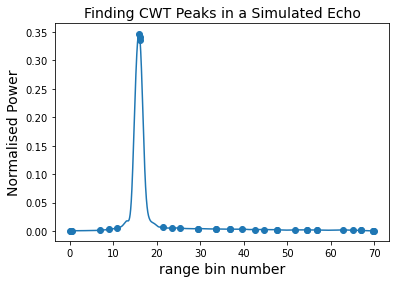

In [11]:
counter = 0
for i in range(len(sim_echoes_1[:][:][:][:])): 
    for j in range(len(sim_echoes_1[0][:][:][:])): 
        for k in range(len(sim_echoes_1[0][0][:][:])):
            for l in range(len(sim_echoes_1[0][0][0][:])):
                sim_echo_params = [sim_params_1[i][j][k][l][0][n] for n in range(len(sim_params_1[i][j][k][l][0]))]
                if str(sim_echo_params) == prediction:
                    print("Echo number: ",counter)
                    simulated_echo_number = counter
                    simulated_echo = [sim_echoes_1[i][j][k][l][m][0] for m in range(len(sim_echoes_1[i][j][k][l])) if m%2==0 ]
                    sim_echo_params = [sim_params_1[i][j][k][l][0][n] for n in range(len(sim_params_1[i][j][k][l][0]))]
                    simulated_echo_area = trapz(simulated_echo, dx = 1) 
                    norm_sim_echo = [x/simulated_echo_area for x in simulated_echo]
                    
                    sim_xnew = np.linspace(0, len(norm_sim_echo)-1, num=(len(norm_sim_echo)*interpolation_factor), endpoint=True)
                    sim_interpolator = interp1d((range(len(norm_sim_echo))), norm_sim_echo, kind='cubic')
                    sim_interpolation = sim_interpolator(sim_xnew)
                    plt.plot(sim_interpolation)
                    #mean scattering surface index accounting for oversampling factor and interpolation factor:
                    mean_scattering_surface_index = list(fasttimes_1[0]).index(0)/2*interpolation_factor
#                     print("mean_scattering_surface_index",mean_scattering_surface_index) 
                    major_peak_index = np.argmax(sim_interpolation) #finding the index of the largest peak in the echo
#                     print("sim_interp_peak_index",major_peak_index)
                    peak_indices = signal.find_peaks(sim_interpolation, width = 150, height = 0.04)[0] #finding all the indices of all the peaks in the echo
                    peak_indices_cwt = signal.find_peaks_cwt(sim_interpolation, widths = np.arange(10, 50, 10))
                    plt.scatter(peak_indices_cwt, sim_interpolation[peak_indices_cwt])
#                     print("peak indices: ",peak_indices)
#                     print(np.argmax(sim_interpolation))
#                     print("peak_indices_cwt: ",peak_indices_cwt)
                    filtered_cwt_distances = [np.argmax(sim_interpolation)-peak_indices_cwt[i] for i in range(len(peak_indices_cwt))
                                              if 40<np.argmax(sim_interpolation)-peak_indices_cwt[i]<600]
                    if len(filtered_cwt_distances)>0:
#                         print("filetered_cwt_distances",filtered_cwt_distances)
                        print("This is a questionable threshold fraction but may be appropriate if a lead is present")
                    #finding the peak-to-trough depth of the largest (major) peak in the echo:
                    max_peak_depth = signal.peak_prominences(sim_interpolation,peak_indices)[0][list(peak_indices).index(major_peak_index)]
                    peak_threshold = sim_interpolation[int(mean_scattering_surface_index)]
#                     print("max peak depth",max_peak_depth)
#                     print("peak threshold", peak_threshold)
                    mean_scattering_surface_threshold_fraction = 1 - (np.max(sim_interpolation) - peak_threshold)/max_peak_depth
                    print("Threshold_fraction: ",mean_scattering_surface_threshold_fraction)

                counter+=1
for i in range(len(sim_echoes_2[:][:][:][:])): 
    for j in range(len(sim_echoes_2[0][:][:][:])): 
        for k in range(len(sim_echoes_2[0][0][:][:])):
            for l in range(len(sim_echoes_2[0][0][0][:])):
                sim_echo_params = [sim_params_2[i][j][k][l][0][n] for n in range(len(sim_params_2[i][j][k][l][0]))]
                if str(sim_echo_params) == prediction:
                    print("Echo number: ",counter)
                    simulated_echo_number = counter
                    simulated_echo = [sim_echoes_2[i][j][k][l][m][0] for m in range(len(sim_echoes_2[i][j][k][l])) if m%2==0 ]
                    sim_echo_params = [sim_params_2[i][j][k][l][0][n] for n in range(len(sim_params_2[i][j][k][l][0]))]
                    simulated_echo_area = trapz(simulated_echo, dx = 1) 
                    norm_sim_echo = [x/simulated_echo_area for x in simulated_echo]
                    
                    sim_xnew = np.linspace(0, len(norm_sim_echo)-1, num=(len(norm_sim_echo)*interpolation_factor), endpoint=True)
                    sim_interpolator = interp1d((range(len(norm_sim_echo))), norm_sim_echo, kind='cubic')
                    sim_interpolation = sim_interpolator(sim_xnew)
                    plt.title("Finding CWT Peaks in a Simulated Echo", fontsize = 14)
                    plt.ylabel("Normalised Power", fontsize = 14)
                    plt.xticks([0,1000,2000,3000,4000,5000,6000,7000], [0,10,20,30,40,50,60,70])
                    plt.xlabel("range bin number", fontsize =14)
                    plt.plot(sim_interpolation)
                    #mean scattering surface index accounting for oversampling factor and interpolation factor:
                    mean_scattering_surface_index = list(fasttimes_2[0]).index(0)/2*interpolation_factor
#                     print("mean_scattering_surface_index",mean_scattering_surface_index) 
                    major_peak_index = np.argmax(sim_interpolation) #finding the index of the largest peak in the echo
#                     print("sim_interp_peak_index",major_peak_index)
                    peak_indices = signal.find_peaks(sim_interpolation, width = 150, height = 0.04)[0] #finding all the indices of all the peaks in the echo
                    peak_indices_cwt = signal.find_peaks_cwt(sim_interpolation, widths = np.arange(10, 50, 10))
                    plt.scatter(peak_indices_cwt, sim_interpolation[peak_indices_cwt])
#                     print("peak indices: ",peak_indices)
#                     print(np.argmax(sim_interpolation))
#                     print("peak_indices_cwt: ",peak_indices_cwt)
                    filtered_cwt_distances = [np.argmax(sim_interpolation)-peak_indices_cwt[i] for i in range(len(peak_indices_cwt))
                                              if 40<np.argmax(sim_interpolation)-peak_indices_cwt[i]<600]
                    if len(filtered_cwt_distances)>0:
#                         print("filtered_cwt_distances", filtered_cwt_distances)
                        print("This could seem like a questionable threshold fraction but may be appropriate if a lead is present off-nadir")
                    #finding the peak-to-trough depth of the largest (major) peak in the echo:
                    max_peak_depth = signal.peak_prominences(sim_interpolation,peak_indices)[0][list(peak_indices).index(major_peak_index)]
                    peak_threshold = sim_interpolation[int(mean_scattering_surface_index)]
#                     print("max peak depth",max_peak_depth)
#                     print("peak threshold", peak_threshold)
                    mean_scattering_surface_threshold_fraction = 1 - (np.max(sim_interpolation) - peak_threshold)/max_peak_depth
                    print("Threshold_fraction: ",mean_scattering_surface_threshold_fraction)

                counter+=1



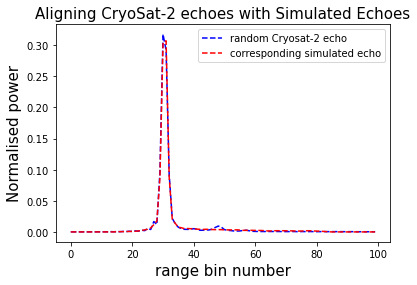

In [15]:
"""Plotting the Cryosat-2 echo and corresponding simulated echo"""

plt.title('Aligning CryoSat-2 echoes with Simulated Echoes', fontsize = 15)
plt.plot(range(len(obs_uninterp)), obs_uninterp, 'b--',label = 'random Cryosat-2 echo')
plt.plot(range(len(feature_arr[simulated_echo_number][20:])), feature_arr[simulated_echo_number][20:], 'r--',label = 'corresponding simulated echo')
# plt.plot(range(len(gaussian)), gaussian, label = 'abstract gaussian both are aligned to')
plt.xlabel('range bin number', fontsize = 15)
plt.ylabel('Normalised power', fontsize = 15)
plt.legend(loc = 'upper right')
plt.savefig('RandomCryoSat2EchoNL.png', dpi= 200)

In [17]:
print("Threshold_fraction: ",mean_scattering_surface_threshold_fraction) 
print("This could seem like a questionable threshold fraction but may be appropriate if a lead is present off-nadir")

Threshold_fraction:  0.10915289310016929
This could seem like a questionable threshold fraction but may be appropriate if a lead is present off-nadir
